In [1]:
# importing the libraries

import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# getting the cpu cores

import os

os.cpu_count()

16

In [3]:
# setting up the model parameters
rand_seed = 42
lr_rate = 0.001
batch_size = 32
epochs = 15

img_sz = 32
classes = 10

In [4]:
# check for gpu if available
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/markins/miniconda3/envs/lenet/lib/python3.11/site-packages/torch/cuda/__init__.py:126: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1689405060148/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
dev

'cpu'

In [6]:
# getting and prep the data 

# data augmentation
image_transformer = transforms.Compose([
                transforms.Resize((20, 20)), # resize the images to 32x32
                transforms.ToTensor() # convert the images to tensors
])

# training data 
train_dataset = datasets.MNIST(root='mnist_data', 
                                train=True,
                                transform=image_transformer,
                                download=True
                              )

# validation dataset
valid_dataset = datasets.MNIST(root='mnist_data',
                                train=False,
                                transform=image_transformer)

# Data loaders
train_dloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)

Text(0.5, 0.98, 'MNIST Preview')

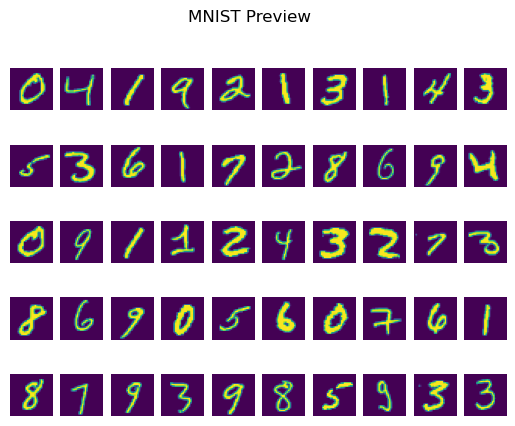

In [7]:
# image visualization
fg = plt.figure()
# image row = 10
# each rows = 5
for indx in range(1, 10*5+1):
    plt.subplot(5, 10, indx)
    plt.axis('off')
    plt.imshow(train_dataset.data[indx])
fg.suptitle("MNIST Preview")

Text(0.5, 0.98, 'MNIST GrayScale Preview')

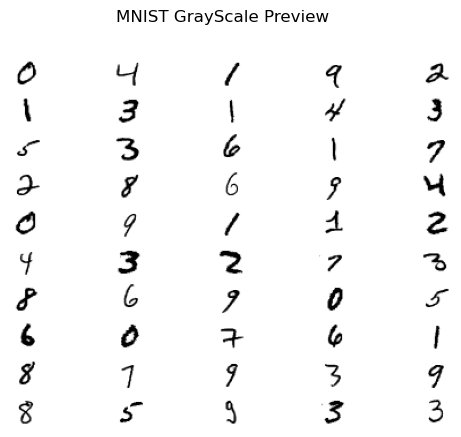

In [8]:
# checking in grayscale
fg = plt.figure()
for indx in range(1, 10*5+1):
    plt.subplot(10, 5, indx)
    plt.axis('off')
    plt.imshow(train_dataset.data[indx], cmap='gray_r')
fg.suptitle('MNIST GrayScale Preview')

In [9]:
def get_acc(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    total_pred = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.to(device)
            y_true = y_true.to(device)
            
            logits = model(X)
            _, predicted_labels = torch.max(logits, 1)
            
            correct_pred += (predicted_labels == y_true).sum().item()
            total_pred += len(y_true)  # Instead of y_true.size(0)

    accuracy = correct_pred / total_pred * 100
    return accuracy


def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

# training engine
def train(train_dloader, model, criterion, optimizer, device):
    '''
        Training Engine
    '''
    model.train()
    curr_loss = 0
    correct_pred = 0 
    total_pred = 0
    
    for x, y_true in train_dloader:
        # backpropagate so setting the grads to zero
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch#48009142
        optimizer.zero_grad()
        
        # set the model to the selected device
        x = x.to(device)
        y_true = y_true.to(device)
        
        # forward prop
        logits = model(x)  # Only use logits
        loss = criterion(logits, y_true)
        curr_loss += loss.item() * x.size(0)
        
        # calculate accuracy within the training loop
        _, predicted_labels = torch.max(logits, 1)
        correct_pred += (predicted_labels == y_true).sum().item()
        total_pred += len(y_true)
        
        # backprop
        loss.backward()
        optimizer.step()
        
    epoch_loss = curr_loss / len(train_dloader.dataset)
    accuracy = correct_pred / total_pred * 100
    return model, optimizer, epoch_loss, accuracy

# validation engine
def validate(valid_dloader, model, criterion, device):
    '''
        Validation Engine
    '''
    model.eval()
    curr_loss = 0
    
    for x, y_true in valid_dloader:
        x = x.to(device)
        y_true = y_true.to(device)
        
        # forward prop
        logits = model(x)  # Only use logits
        loss = criterion(logits, y_true)
        curr_loss += loss.item() * x.size(0)
        
    epoch_loss = curr_loss / len(valid_dloader.dataset)
    return model, epoch_loss


# creating a training loop engine
def train_engine(model, criterion, optimizer, train_dloader, 
                 valid_dloader, epochs, device, verbose=1):
    '''
        Training Loop Engine defined for the models
    '''
    
    # baseline training metrics
    loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracies = []  # Track train accuracies
    valid_accuracies = []  # Track validation accuracies
    
    for epoch in range(0, epochs):
        # training 
        model, optimizer, train_loss, train_accuracy = train(train_dloader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)  # Append the train accuracy
        
        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_dloader, model, criterion, device)
            valid_losses.append(valid_loss)
            valid_accuracy = get_acc(model, valid_dloader, device=device)  # Calculate validation accuracy
            valid_accuracies.append(valid_accuracy)  # Append the validation accuracy
            
        if epoch % verbose == (verbose - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {train_accuracy:.2f}\t'
                  f'Valid accuracy: {valid_accuracy:.2f}')
            
    plot_losses(train_losses, valid_losses)
    return model, optimizer, (train_losses, valid_losses, train_accuracies, valid_accuracies)

# BaseLine Classifier

In [10]:
# Baseline Classifier

class LinearClassifier(nn.Module):
    def __init__(self, input_size, classes):
        super(LinearClassifier, self).__init__()

        # Define the fully connected layer
        # 20 * 20 --> 400 mapped to 10
        self.fc = nn.Linear(input_size, classes)
    
    def forward(self, x):
        # Flatten the input tensor to a 1D tensor
        x = torch.flatten(x, 1)
        
        # Pass the flattened input through the fully connected layer
        logits = self.fc(x)
        
        # Return the output logits
        return logits

In [11]:
torch.manual_seed(rand_seed)
input_size = 20*20
model = LinearClassifier(input_size, classes).to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

15:38:19 --- Epoch: 0	Train loss: 0.5869	Valid loss: 0.3482	Train accuracy: 86.27	Valid accuracy: 90.94
15:38:26 --- Epoch: 1	Train loss: 0.3382	Valid loss: 0.3019	Train accuracy: 90.66	Valid accuracy: 91.71
15:38:33 --- Epoch: 2	Train loss: 0.3067	Valid loss: 0.2868	Train accuracy: 91.48	Valid accuracy: 91.76
15:38:41 --- Epoch: 3	Train loss: 0.2923	Valid loss: 0.2769	Train accuracy: 91.82	Valid accuracy: 92.14
15:38:48 --- Epoch: 4	Train loss: 0.2836	Valid loss: 0.2732	Train accuracy: 92.03	Valid accuracy: 92.26
15:38:55 --- Epoch: 5	Train loss: 0.2781	Valid loss: 0.2688	Train accuracy: 92.16	Valid accuracy: 92.51
15:39:02 --- Epoch: 6	Train loss: 0.2740	Valid loss: 0.2668	Train accuracy: 92.31	Valid accuracy: 92.61
15:39:10 --- Epoch: 7	Train loss: 0.2707	Valid loss: 0.2651	Train accuracy: 92.35	Valid accuracy: 92.60
15:39:17 --- Epoch: 8	Train loss: 0.2680	Valid loss: 0.2634	Train accuracy: 92.48	Valid accuracy: 92.68
15:39:25 --- Epoch: 9	Train loss: 0.2659	Valid loss: 0.2616	Trai

/tmp/ipykernel_7474/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_7474/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


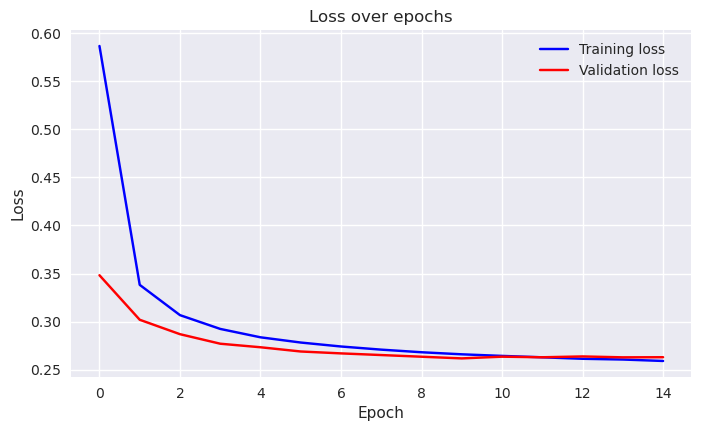

In [12]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader, valid_dloader, epochs, dev)

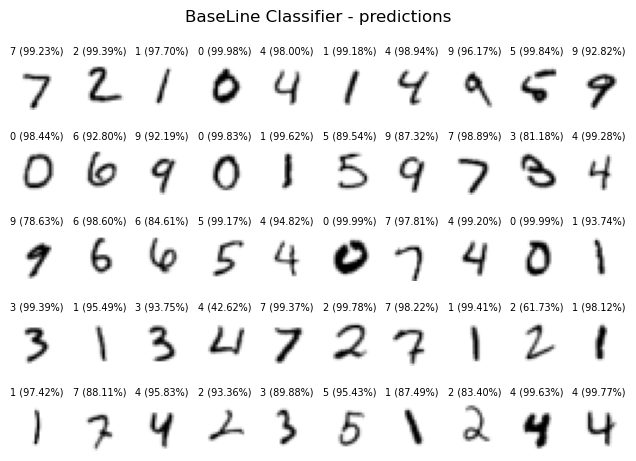

In [13]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
# the minimum of the total number of images in the valid_dataset and the product of ROW_IMG and N_ROWS, ensuring that the plot won't exceed the available data.
num_subplots = min(len(valid_dataset), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    """
     loop iterates through the num_subplots and creates a subplot at the current index. It turns off the axis for each subplot, making the plot cleaner without any axis ticks.
    """
    img = valid_dataset[index][0].unsqueeze(0).to(dev)
    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    """
    It fetches the image tensor from the valid_dataset at the current index and converts it to a 4-dimensional tensor with a batch size of 1 (unsqueeze). 
    The image tensor is then moved to the device dev (presumably GPU) for faster processing. 
    Finally, the image is displayed using imshow, and the gray_r colormap is used to display the image in grayscale.
    """
    with torch.no_grad():
        model.eval()
        probs = model(img)
    # The model is put into evaluation mode (model.eval()) and a forward pass is made with the image tensor img. 
    # The output probs will contain the probability distribution of the model's predictions.
    label = valid_dataset[index][1]  # Access the label directly
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100  # Calculate max probability
    title = f'{label} ({probability:.2f}%)'

    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('BaseLine Classifier - predictions')
plt.show()

#  One-Hidden-Layer Fully Connected Multilayer Neural Network

In [15]:
class OneHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size, classes):
        super(OneHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, classes)
        
    def forward(self, x):
        # Flatten the input tensor along the second dimension to convert images into a 1D vector
        x = torch.flatten(x, 1)

        # Pass the flattened input through the first hidden layer, applying the ReLU activation function
        x = torch.relu(self.fc1(x))

        # Compute the logits (raw predictions) for each class using the second fully connected layer
        logits = self.fc2(x)

        # Return the logits, which can be further processed to obtain probabilities using a softmax function
        return logits

In [16]:
torch.manual_seed(rand_seed)
input_size = 20*20
hidden_size = 300
model = OneHiddenLayer(input_size, hidden_size, classes).to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

15:40:12 --- Epoch: 0	Train loss: 0.2851	Valid loss: 0.1408	Train accuracy: 91.98	Valid accuracy: 95.90
15:40:20 --- Epoch: 1	Train loss: 0.1226	Valid loss: 0.1044	Train accuracy: 96.35	Valid accuracy: 96.99
15:40:29 --- Epoch: 2	Train loss: 0.0864	Valid loss: 0.0907	Train accuracy: 97.32	Valid accuracy: 97.23
15:40:37 --- Epoch: 3	Train loss: 0.0669	Valid loss: 0.0711	Train accuracy: 97.98	Valid accuracy: 97.64
15:40:46 --- Epoch: 4	Train loss: 0.0538	Valid loss: 0.0687	Train accuracy: 98.34	Valid accuracy: 98.01
15:40:54 --- Epoch: 5	Train loss: 0.0438	Valid loss: 0.0723	Train accuracy: 98.64	Valid accuracy: 97.76
15:41:02 --- Epoch: 6	Train loss: 0.0362	Valid loss: 0.0661	Train accuracy: 98.88	Valid accuracy: 97.96
15:41:10 --- Epoch: 7	Train loss: 0.0311	Valid loss: 0.0600	Train accuracy: 98.99	Valid accuracy: 98.14
15:41:18 --- Epoch: 8	Train loss: 0.0246	Valid loss: 0.0621	Train accuracy: 99.27	Valid accuracy: 98.19
15:41:26 --- Epoch: 9	Train loss: 0.0216	Valid loss: 0.0696	Trai

/tmp/ipykernel_7474/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_7474/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


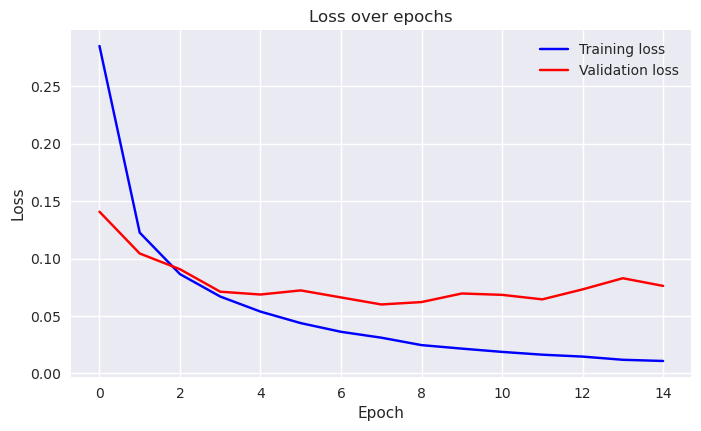

In [17]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader, valid_dloader, epochs, dev)

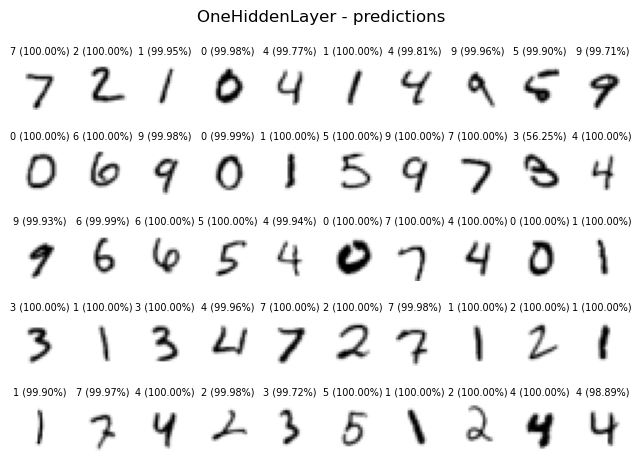

In [18]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
# the minimum of the total number of images in the valid_dataset and the product of ROW_IMG and N_ROWS, ensuring that the plot won't exceed the available data.
num_subplots = min(len(valid_dataset), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    """
     loop iterates through the num_subplots and creates a subplot at the current index. It turns off the axis for each subplot, making the plot cleaner without any axis ticks.
    """
    img = valid_dataset[index][0].unsqueeze(0).to(dev)
    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    """
    It fetches the image tensor from the valid_dataset at the current index and converts it to a 4-dimensional tensor with a batch size of 1 (unsqueeze). 
    The image tensor is then moved to the device dev (presumably GPU) for faster processing. 
    Finally, the image is displayed using imshow, and the gray_r colormap is used to display the image in grayscale.
    """
    with torch.no_grad():
        model.eval()
        probs = model(img)
    # The model is put into evaluation mode (model.eval()) and a forward pass is made with the image tensor img. 
    # The output probs will contain the probability distribution of the model's predictions.
    label = valid_dataset[index][1]  # Access the label directly
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100  # Calculate max probability
    title = f'{label} ({probability:.2f}%)'

    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('OneHiddenLayer - predictions')
plt.show()

# Two Hidden Layer Fully Connected Multilayer Neural Network

In [19]:
# Tranform and form the resize the image to 28 * 28 

# getting and prep the data 

# data augmentation
image_transformer_two_hd_layer = transforms.Compose([
                transforms.Resize((28, 28)), # resize the images to 32x32
                transforms.ToTensor() # convert the images to tensors
])

# training data 
train_dataset_two_hd_layer = datasets.MNIST(root='mnist_data_two_hidden_layer', 
                                train=True,
                                transform=image_transformer_two_hd_layer,
                                download=True
                              )

# validation dataset
valid_dataset_two_hd_layer = datasets.MNIST(root='mnist_data_two_hidden_layer',
                                train=False,
                                transform=image_transformer_two_hd_layer)

# Data loaders
train_dloader_two_hd_layer = DataLoader(dataset=train_dataset_two_hd_layer, batch_size=batch_size, shuffle=True)
valid_dloader_two_hd_layer = DataLoader(dataset=valid_dataset_two_hd_layer, batch_size=batch_size, shuffle=True)

Text(0.5, 0.98, 'MNIST GrayScale Preview After 28*28')

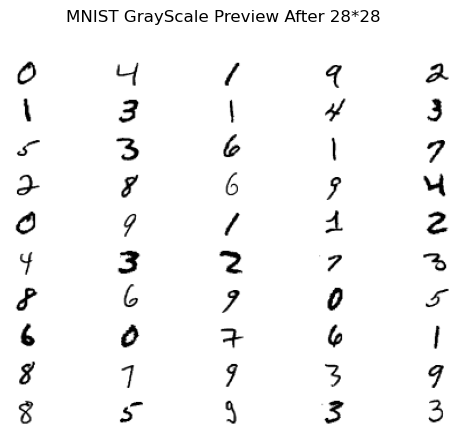

In [20]:
# checking in grayscale
fg = plt.figure()
for indx in range(1, 10*5+1):
    plt.subplot(10, 5, indx)
    plt.axis('off')
    plt.imshow(train_dataset.data[indx], cmap='gray_r')
fg.suptitle('MNIST GrayScale Preview After 28*28')

In [21]:
# Two Hidden Layer Fully Connected 
class TwoHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, classes):
        super(TwoHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, classes)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [22]:
torch.manual_seed(rand_seed)
input_size = 28*28
hidden_size1 = 300
hidden_size2 = 100
model = TwoHiddenLayer(input_size, hidden_size1, hidden_size2,classes).to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
criterion = nn.CrossEntropyLoss()

15:42:19 --- Epoch: 0	Train loss: 0.2421	Valid loss: 0.1266	Train accuracy: 92.87	Valid accuracy: 95.95
15:42:28 --- Epoch: 1	Train loss: 0.0957	Valid loss: 0.0995	Train accuracy: 97.09	Valid accuracy: 96.68
15:42:36 --- Epoch: 2	Train loss: 0.0633	Valid loss: 0.0754	Train accuracy: 97.97	Valid accuracy: 97.70
15:42:44 --- Epoch: 3	Train loss: 0.0467	Valid loss: 0.0756	Train accuracy: 98.48	Valid accuracy: 97.80
15:42:53 --- Epoch: 4	Train loss: 0.0359	Valid loss: 0.0762	Train accuracy: 98.86	Valid accuracy: 97.60
15:43:01 --- Epoch: 5	Train loss: 0.0293	Valid loss: 0.0763	Train accuracy: 99.03	Valid accuracy: 97.83
15:43:09 --- Epoch: 6	Train loss: 0.0234	Valid loss: 0.0811	Train accuracy: 99.20	Valid accuracy: 97.80
15:43:17 --- Epoch: 7	Train loss: 0.0214	Valid loss: 0.0755	Train accuracy: 99.28	Valid accuracy: 97.97
15:43:26 --- Epoch: 8	Train loss: 0.0179	Valid loss: 0.0803	Train accuracy: 99.40	Valid accuracy: 98.11
15:43:34 --- Epoch: 9	Train loss: 0.0161	Valid loss: 0.0855	Trai

/tmp/ipykernel_7474/2141866378.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/tmp/ipykernel_7474/2141866378.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


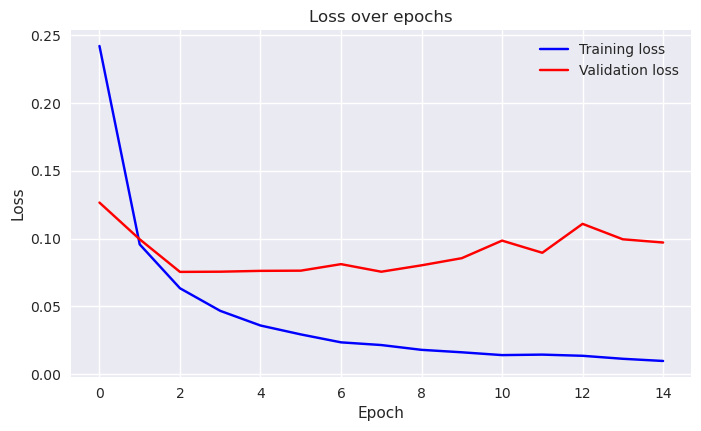

In [23]:
model, optimizer, _ = train_engine(model, criterion, optimizer, train_dloader_two_hd_layer, valid_dloader_two_hd_layer, epochs, dev)

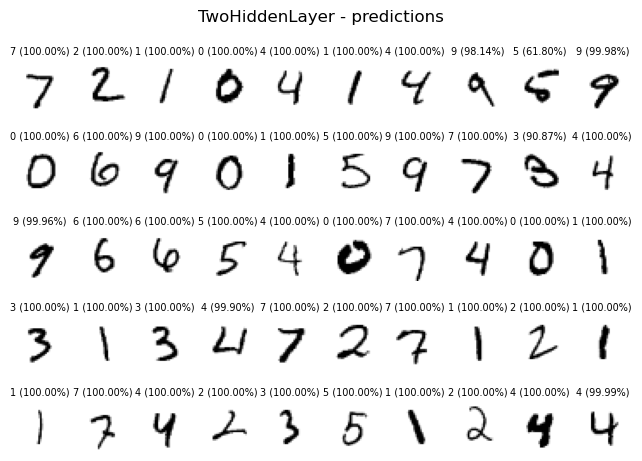

In [24]:
# visualizing the predictions

ROW_IMG = 10
N_ROWS = 5

model = model.to(dev)

fig = plt.figure()
num_subplots = min(len(valid_dataset_two_hd_layer), ROW_IMG * N_ROWS)
for index in range(num_subplots):
    plt.subplot(N_ROWS, ROW_IMG, index + 1)
    plt.axis('off')
    
    # Get the image and convert it back to a PIL Image
    img, _ = valid_dataset_two_hd_layer[index]
    img_pil = transforms.ToPILImage()(img)

    # Preprocess the PIL Image using the same transformer used during training
    img = image_transformer_two_hd_layer(img_pil).unsqueeze(0).to(dev)

    plt.imshow(img.squeeze().cpu(), cmap='gray_r')
    
    # The rest of the visualization loop remains unchanged
    with torch.no_grad():
        model.eval()
        probs = model(img)
    label = valid_dataset_two_hd_layer[index][1]
    probability = torch.max(torch.softmax(probs, dim=1), dim=1).values.item() * 100
    title = f'{label} ({probability:.2f}%)'
    plt.title(title, fontsize=7)

# Adjust the layout to avoid overlapping titles
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('TwoHiddenLayer - predictions')
plt.show()

In [14]:
# TODO ---> LeNet-1 , LeNet-4 , LeNet-5